# rACS in Real-Multiplexer

In [36]:
# Logger
import logging
logging.basicConfig(level=logging.INFO)

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['pdf.use14corefonts'] = True

# Import local paths
import sys, os
sys.path.append(os.path.abspath('../../..'))
sys.path.append(os.path.abspath('../../../../openai-envs'))

# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# Load PyALCS module
from lcs.representations.RealValueEncoder import RealValueEncoder
from lcs.agents.racs import RACS, Configuration

# Load OpenAI environments
import gym
import gym_multiplexer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Real-Multiplexer
In 3-bit multiplexer first bit is responsible for addressing the correct answer.

> For testing purposes the last bit is used as a flag indicating if the action chosen by the algorithm was correct. The environment always introduces it with 0. It's value is changed to 1 if the action was chosen correctly.

In [2]:
# Environment initialization
rmpx = gym.make('real-multiplexer-3bit-v0')

rMPX acts like a normal MPX with the difference that instead on boolean values floating numbers within range `[0,1]` are used. Environment used internal threshold to transform them into boolean values (`threshold=0.5` is used as default).

In [3]:
state = rmpx.reset()
state

[0.1516732270278892, 0.217448987381483, 0.7332952884765859, 0.0]

Which corresponds to the following binary MPX:

In [4]:
threshold = 0.5  # secret knowledge
binary_state = map(lambda x: 1 if x > threshold else 0, state)

list(binary_state)

[0, 0, 1, 0]

Depending on the MPX size we have some actions to be executed. In 3-bit variant first bit (_address bit_) points to the correct answer (two possible values).

In [5]:
rmpx.action_space.n

2

We can also investigate the properties of a single observation (like vector dimension, lower and upper bound of each attribute).

In [6]:
print(f"Observation shape: {rmpx.observation_space.shape}")
print(f"Upper bounds: {rmpx.observation_space.low}")
print(f"Lower bounds: {rmpx.observation_space.high}")

Observation shape: (4,)
Upper bounds: [0. 0. 0. 0.]
Lower bounds: [1. 1. 1. 1.]


## rACS

In [7]:
def encode(bits, val):
    return int(RealValueEncoder(bits).encode(val))

r = np.arange(0, 1.1, .1)

df = pd.DataFrame(r, columns=['Perception'])

for bit in [1, 2, 3, 4, 5, 6, 7]:
    df[f'{bit}-bit'] = df.apply(lambda row: encode(bit, row['Perception']), axis=1)

df.set_index('Perception', inplace=True)
df

,1-bit,2-bit,3-bit,4-bit,5-bit,6-bit,7-bit
Perception,,,,,,,
0.0,0,0,0,0,0,0,0
0.1,0,0,0,1,3,6,12
0.2,0,0,1,3,6,12,25
0.3,0,1,2,4,9,19,38
0.4,0,1,3,6,12,25,51
0.5,1,2,4,8,16,32,64
0.6,1,2,4,9,19,38,76
0.7,1,2,5,11,22,44,89
0.8,1,3,6,12,25,51,102


## Experiment
In the experiment each attribute range will be represented as an _unorded bounded tuple_ with desired encoding resolution.

In [8]:
# Define function for fetching interesing metrics
def rmpx_metrics(population, environment):
    return {
        'population': len(population),
        'numerosity': sum(cl.num for cl in population),
        'reliable': len([cl for cl in population if cl.is_reliable()])
    }

Define a function for executing experiments

In [9]:
def perform_experiment(env, encoder_bits, trials):
    # create configuration
    cfg = Configuration(env.observation_space.shape[0], env.action_space.n,
                    encoder=RealValueEncoder(encoder_bits),
                    metrics_trial_frequency=5,
                    user_metrics_collector_fcn=rmpx_metrics,
                    epsilon=1.0,  # no biased exploration
                    do_ga=True,
                    theta_r=0.9,  # reliablity threshold
                    theta_i=0.2,  # inadequacy threshold
                    theta_ga=100,
                    cover_noise=0,
                    mutation_noise=0.25,
                    chi=1.0,  # cross-over probability
                    mu=0.1)  # mutation probability
    
    # create agent
    agent = RACS(cfg)
    
    # run computations
    population, metrics = agent.explore_exploit(env, trials)
    
    return population, metrics

## Data visualization

In [10]:
def parse_metrics(metrics):
    lst = [[d['trial'], d['reward'], d['population'], d['reliable']] for d in metrics]

    df = pd.DataFrame(lst, columns=['trial', 'reward', 'population', 'reliable'])
    df = df.set_index('trial')
    df['mode'] = df.index.map(lambda t: "explore" if t % 2 == 0 else "exploit")

    return df

In [41]:
def plot_results(metrics, env, encoder_bits, major_ticker_freq=2000, out_path=None):
    # parse metrics into data frame
    df = parse_metrics(metrics)
    
    # separate explore/exploit data
    explore_df = df[df['mode'] == 'explore']
    exploit_df = df[df['mode'] == 'exploit']
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    f.suptitle(f"{env.env.spec.id}, ubr encoder bits: {encoder_bits}", fontsize=14)
    
    # plot 1 - average reward
    explore_df['reward'].rolling(window=50).mean().plot(label='explore', ax=ax1)
    exploit_df['reward'].rolling(window=50).mean().plot(label='exploit', ax=ax1)

    ax1.axhline(y=500, color='black', linestyle='--', linewidth=1)
    ax1.axhline(y=1000, color='black', linestyle='--', linewidth=1)

    # ax1.annotate('maximum reward', xy=(500, 950), xycoords='data')
        
    ax1.set_title('Average reward')
    ax1.set_xlabel('Trial')
    ax1.set_ylabel('Average reward')
    ax1.set_ylim(400, 1100)
    
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(major_ticker_freq))
    
    ax1.legend()
    
    # plot 2 - number of classifiers
    df['population'].plot(label='population', ax=ax2)
    df['reliable'].plot(label='reliable', ax=ax2)
    
    ax2.set_title("Classifiers evolution")
    ax2.set_xlabel('Trial')
    ax2.set_ylabel('# Classifiers')
    
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(major_ticker_freq))
    
    ax2.legend()
    
    if out_path:
        f.savefig(out_path, bbox_inches='tight')

## Experiments

In [12]:
def evaluate(rmpx, encoder_bits, trials=10_000):
    population, metrics = perform_experiment(rmpx, encoder_bits=encoder_bits, trials=trials)
    
    # sort classifiers in population according to action
    population = sorted(population, key=lambda cl: cl.action)

    return population, metrics

### 3-bit rMPX

In [13]:
rmpx3 = gym.make('real-multiplexer-3bit-v0')

In [40]:
%%time
_, metrics1 = evaluate(rmpx3, encoder_bits=1, trials=10_000)

INFO:lcs.agents.Agent:{'trial': 0, 'steps_in_trial': 1, 'reward': 0, 'population': 1, 'numerosity': 1, 'reliable': 0}
INFO:lcs.agents.Agent:{'trial': 5000, 'steps_in_trial': 1, 'reward': 1000, 'population': 8, 'numerosity': 160, 'reliable': 8}


CPU times: user 8.83 s, sys: 53 ms, total: 8.88 s
Wall time: 9.2 s


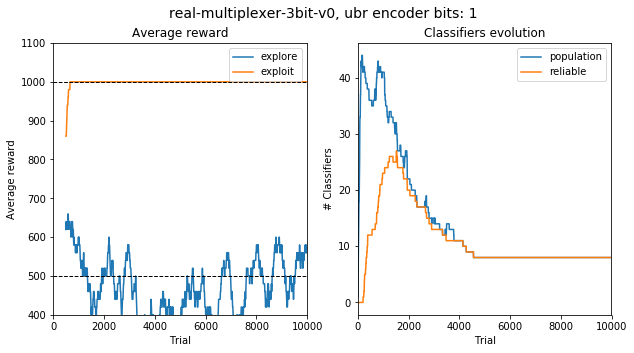

In [43]:
plot_results(metrics1, rmpx3, encoder_bits=1, out_path = 'rmpx3bit_ubr1bit.pdf')

In [31]:
%%time
pop2, metrics2 = evaluate(rmpx3, encoder_bits=2, trials=15_000)

INFO:lcs.agents.Agent:{'trial': 0, 'steps_in_trial': 1, 'reward': 1000, 'population': 1, 'numerosity': 1, 'reliable': 0}
INFO:lcs.agents.Agent:{'trial': 5000, 'steps_in_trial': 1, 'reward': 1000, 'population': 61, 'numerosity': 578, 'reliable': 41}
INFO:lcs.agents.Agent:{'trial': 10000, 'steps_in_trial': 1, 'reward': 0, 'population': 31, 'numerosity': 508, 'reliable': 31}


CPU times: user 30.3 s, sys: 42.5 ms, total: 30.4 s
Wall time: 30.4 s


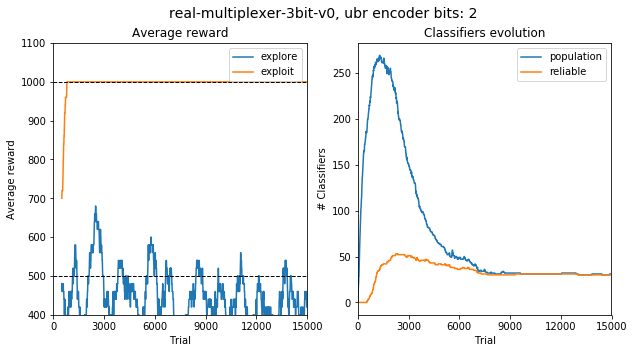

In [44]:
plot_results(metrics2, rmpx3, encoder_bits=2, major_ticker_freq=3000, out_path = 'rmpx3bit_ubr2bit.pdf')

In [33]:
from itertools import groupby

rel = [cl for cl in pop2 if cl.is_reliable()]

for k, g in groupby(rel, key=lambda cl: cl.action):
    niche = list(g)
    print(f'\nAction: {k}, classifiers: {len(niche)}')
    for cl in sorted(niche, key=lambda cl: -cl.fitness):
        print(f'{cl}')


Action: 0, classifiers: 15
OO..|O...|OOOO|O...	0	OOOO|OOOO|OOOO|...O x 20 fitness: 1000.00
..OO|OOOO|.O..|O...	0	OOOO|OOOO|OOOO|...O x 20 fitness: 1000.00
OO..|.O..|OOOO|O...	0	OOOO|OOOO|OOOO|...O x 20 fitness: 1000.00
..O.|OOOO|O...|O...	0	OOOO|OOOO|OOOO|...O x 20 fitness: 1000.00
...O|OOOO|O...|O...	0	OOOO|OOOO|OOOO|...O x 20 fitness: 1000.00
.O..|..O.|O...|OOOO	0	OOOO|OOOO|OOOO|OOOO x 1 fitness: 12.84
...O|OOOO|..O.|OOOO	0	OOOO|OOOO|OOOO|OOOO x 5 fitness: 0.00
..O.|OOOO|..O.|OOOO	0	OOOO|OOOO|OOOO|OOOO x 16 fitness: 0.00
.O..|...O|OOOO|OOOO	0	OOOO|OOOO|OOOO|OOOO x 20 fitness: 0.00
.O..|..O.|OOOO|OOOO	0	OOOO|OOOO|OOOO|OOOO x 4 fitness: 0.00
..O.|OOOO|...O|OOOO	0	OOOO|OOOO|OOOO|OOOO x 1 fitness: 0.00
O...|..O.|OOOO|OOOO	0	OOOO|OOOO|OOOO|OOOO x 20 fitness: 0.00
O...|...O|OOOO|OOOO	0	OOOO|OOOO|OOOO|OOOO x 20 fitness: 0.00
...O|OOOO|...O|OOOO	0	OOOO|OOOO|OOOO|OOOO x 9 fitness: 0.00
.OOO|..O.|..OO|OOOO	0	OOOO|OOOO|OOOO|OOOO x 18 fitness: 0.00

Action: 1, classifiers: 15
O...|...O|OOOO|O..

In [34]:
%%time
_, metrics = evaluate(rmpx3, encoder_bits=3, trials=20_000)

INFO:lcs.agents.Agent:{'trial': 0, 'steps_in_trial': 1, 'reward': 1000, 'population': 1, 'numerosity': 1, 'reliable': 0}
INFO:lcs.agents.Agent:{'trial': 5000, 'steps_in_trial': 1, 'reward': 0, 'population': 1290, 'numerosity': 2353, 'reliable': 49}
INFO:lcs.agents.Agent:{'trial': 10000, 'steps_in_trial': 1, 'reward': 1000, 'population': 1278, 'numerosity': 3011, 'reliable': 81}
INFO:lcs.agents.Agent:{'trial': 15000, 'steps_in_trial': 1, 'reward': 1000, 'population': 1322, 'numerosity': 3727, 'reliable': 98}


CPU times: user 9min 8s, sys: 2.47 s, total: 9min 10s
Wall time: 9min 58s


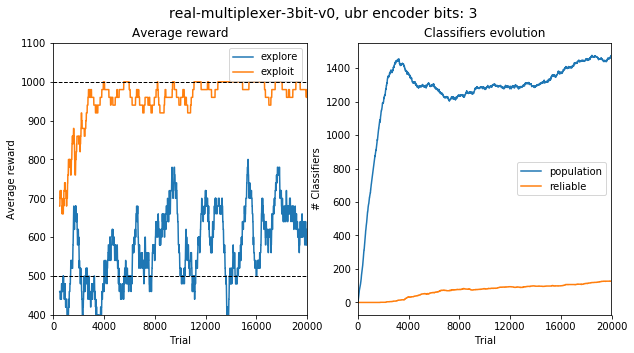

In [50]:
plot_results(metrics, rmpx3, encoder_bits=3, major_ticker_freq=4000, out_path = 'rmpx3bit_ubr3bit.pdf')

In [48]:
#%%time
_, metrics4 = evaluate(rmpx3, encoder_bits=4, trials=40_000)

INFO:lcs.agents.Agent:{'trial': 0, 'steps_in_trial': 1, 'reward': 1000, 'population': 1, 'numerosity': 1, 'reliable': 0}
INFO:lcs.agents.Agent:{'trial': 5000, 'steps_in_trial': 1, 'reward': 0, 'population': 3877, 'numerosity': 5047, 'reliable': 3}
INFO:lcs.agents.Agent:{'trial': 10000, 'steps_in_trial': 1, 'reward': 1000, 'population': 4578, 'numerosity': 6902, 'reliable': 14}
INFO:lcs.agents.Agent:{'trial': 15000, 'steps_in_trial': 1, 'reward': 1000, 'population': 5377, 'numerosity': 8535, 'reliable': 22}
INFO:lcs.agents.Agent:{'trial': 20000, 'steps_in_trial': 1, 'reward': 1000, 'population': 5788, 'numerosity': 9681, 'reliable': 27}
INFO:lcs.agents.Agent:{'trial': 25000, 'steps_in_trial': 1, 'reward': 1000, 'population': 6365, 'numerosity': 11163, 'reliable': 44}
INFO:lcs.agents.Agent:{'trial': 30000, 'steps_in_trial': 1, 'reward': 1000, 'population': 6862, 'numerosity': 12638, 'reliable': 62}
INFO:lcs.agents.Agent:{'trial': 35000, 'steps_in_trial': 1, 'reward': 0, 'population': 720

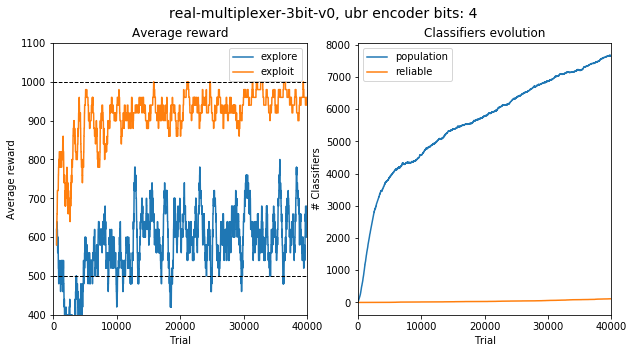

In [51]:
plot_results(metrics4, rmpx3, encoder_bits=4, major_ticker_freq=10000, out_path = 'rmpx3bit_ubr4bit.pdf')